In [ ]:
# !pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121
# !pip install  dgl -f https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html
# !pip install seaborn

Versión de DGL: 2.4.0+cu121
Versión de PyTorch: 2.3.0+cu121


In [2]:
# Reload modulos automaticamente
%load_ext autoreload
%autoreload 2

from modules.gnn_models import GCN, GraphSAGE, GAT
from modules.graph import Graph, create_files
from modules.gnn import GNN
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

# from modules.gnn import GNN
# from modules.models import  ModelGraphSAGE, GraphSAGE, GCN, ModelGCN, ModelSAGESample #ModelGraphSAGE,GraphSAGE, GCN,ModelSAGESample,SAGE, ModelGCN
# from modules.predictors import DotPredictor, MLPPredictor, MLPPredictorEmbeddings
# from modules.graph_from_api import Graph_API
# from dgl.sampling import pack_traces

# import torch.nn.functional as F
# from torch.optim import Adam
# from torch.optim import SparseAdam
import itertools
import dgl
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.metrics import (
    confusion_matrix,              # ya lo estabas usando
    accuracy_score,
    precision_recall_fscore_support,
    classification_report
)
# from utils import *
# from modules.graph import Graph
# import numpy as np
import os
# import fnmatch
# import tqdm
# import networkx as nx

# import dgl.function as fn
# from dgl.nn import DeepWalk
# from torch.utils.data import DataLoader

# from sklearn.linear_model import LogisticRegression
# from gensim.models import Word2Vec
# from sklearn.model_selection import train_test_split
# from bgp2vec.bgp2vec import BGP2VEC


print("Versión de DGL:", dgl.__version__)
print("Versión de PyTorch:", torch.__version__)

/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Versión de DGL: 2.4.0+cu121
Versión de PyTorch: 2.3.0+cu121


In [3]:
TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}

models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

In [4]:
# Definimos las rutas de los archivos
BASE_PROJECT_PATH = os.getcwd() + "/data/"
RELATIONSHIPS_FILE  = BASE_PROJECT_PATH + "CAIDA_AS_Relationships/Serial_1/20220701.as-rel.txt.bz2"
FEATURES_FILE = BASE_PROJECT_PATH + "/node_feature_mio.csv" #"/node_features.csv" 
rib_path = BASE_PROJECT_PATH + 'sanitized_rib.txt'
MES = 'febrero'
dataset_graph_path = BASE_PROJECT_PATH + f'dgl_graph/{MES}/'
MAX_NUM_ROUTES = 1000000

In [5]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Matriz de confusión',
                          fname=None,
                          cmap=plt.cm.Blues,
                          save=False):
    """
    Esta función imprime y grafica la matriz de confusión.
    La normalización puede aplicarse configurando `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confusión sin normalizar')

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Etiqueta real')
    plt.xlabel('Etiqueta predicha')
    plt.tight_layout()
    
    if save and fname is not None:
        plt.savefig(f"{fname}.png", dpi=300, bbox_inches='tight')
    plt.show()


## Creacion Grafo 
Creamos un grafo nx y dgl, ademas de los archivos edges.csv y nodes.csv a partir de archivos ribs previamente creados o de archivo CAIDA AS Relationships.

Crear esos archivos una unica vez con create_graph() una ves ya creados los archivos edges.csv y nodes.csv puedo ocupar directamente la funcion 

Se le puede indicar el maximo de bgp paths que se quiere (hehco para cuando se leen ribs no de caida) 

### CASO 1: RIBs
* Creacion de grafo a partir de paths recolectados de las RIBs por BGPStream
* Por ahora le asignamos a todos los nodos embeddings iniciales de de dimension 32 parte con puros 1s todos


In [ ]:
ls /media/valentina/KINGSTON/TESIS/data/RIBs/sanitized_rib_febrero_2024

rib_abril_2024.txt*            sanitized_rib_enero_2024.txt*
rib_enero_2024.txt*            sanitized_rib_febrero_2024.txt*
rib_marzo_2024.txt*            sanitized_rib_marzo_2024.txt*
sanitized_rib_abril_2024.txt*


In [4]:
# Informacion del analisis para la configuracion
MES = 'febrero'
ANO = '2024'

In [12]:
# Ruta a la data base del proyecto
BASE_PROJECT_PATH = os.getcwd() + "/data/"

# Ruta memoria externa con los datos
DATA_PATH = '/media/valentina/KINGSTON/TESIS/data/'

# Archivo etiqueta las relaciones
LABEL_EDGES_FILE = 'data/' + 'CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'

# Archivo con RIBs
RIB_FILE = DATA_PATH + f'RIBs/sanitized_rib_{MES}_{ANO}.txt'

# Ruta donde se guardaran los grafo DGL
OUTPUT_DIR = BASE_PROJECT_PATH +  f'dgl_graph/{MES}/'

NameError: name 'ANO' is not defined

In [ ]:
# Ruta a la data base del proyecto
BASE_PROJECT_PATH = os.getcwd() + "/data/"

# Ruta memoria externa con los datos
DATA_PATH = '/media/valentina/KINGSTON/TESIS/data/'

# Archivo etiqueta las relaciones
LABEL_EDGES_FILE = DATA_PATH + 'CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'

# Archivo con RIBs
RIB_FILE = DATA_PATH + f'RIBs/sanitized_rib_{MES}_{ANO}.txt'

# Ruta donde se guardaran los grafo DGL
OUTPUT_DIR = BASE_PROJECT_PATH +  f'dgl_graph/{MES}/'
# Definimos las listas de features

# features_file = 'node_degrees' #'' # 'node_degrees' # las features que se le agregaran seran 
# features_file = base_path + "/node_features.csv"
FEATURES_FILE = BASE_PROJECT_PATH + "/node_features_mio_febrero.csv"
# FEATURES_FILE = 'node_features_mio_febrero.csv'
attr = 'node_features_mio_febrero.csv' # 'mio_attr' # 'degree' # 'node_features_mio_febrero.csv'
rib_path = BASE_PROJECT_PATH + 'sanitized_rib_febrero_2024.txt'
MAX_NUM_ROUTES = 1000000
label_edges_file = BASE_PROJECT_PATH + 'edges_labels.csv'
graph_case1 = create_files(
            output_dir = OUTPUT_DIR,
            rib_file = RIB_FILE, 
            features_file = FEATURES_FILE, 
            from_caida = False, 
            label_edges_file = LABEL_EDGES_FILE,
            remove_degree=3,
            debug=True,
            max_paths = MAX_NUM_ROUTES)

print('[NX Graph]',graph_case1.nx_graph)

[CARPETA CREADA]:  /home/valentina/Desktop/GIT/TrabajoTesis/data/dgl_graph/febrero/
[Creando topologia desde /media/valentina/KINGSTON/TESIS/data/RIBs/sanitized_rib_febrero_2024.txt]
[NX Graph]:  DiGraph with 42242 nodes and 149763 edges
[Agregando attr a nodos desde /home/valentina/Desktop/GIT/TrabajoTesis/data//node_features_mio_febrero.csv]
[NX Graph]:  DiGraph with 42242 nodes and 149763 edges
[Etiquetando aristas con CAIDA]
[INFO] Se eliminaron 8382 aristas sin 'Relationship'
[META CREADO]
[NX Graph eliminando]:  DiGraph with 25434 nodes and 124614 edges
[NX Graph eliminando]:  DiGraph with 25088 nodes and 124269 edges
[NX Graph eliminando]:  DiGraph with 25077 nodes and 124258 edges
[NX Graph] DiGraph with 25077 nodes and 124258 edges


## Entrenamiento

### CASO 1: 
* Encoder : GNN -> (GCN , GraphSAGE, GAT)
* Decoder : DotProduct

In [6]:

# DATA_PATH = '/media/valentina/KINGSTON/TESIS'
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
# rib_path = '/media/valentina/KINGSTON/TESIS/data/RIBs/sanitized_rib_febrero_2024.txt'

# # Grafo Internet con Grado
# INTERNETGRAPH_FILE ='/media/valentina/KINGSTON/TESIS/nternetGraphs2024Degree/'

# # Grafo Internet con datos 2022
# INTERNETGRAPH_FILE ='/media/valentina/KINGSTON/TESIS/InternetGNNData2022/'

# Grafo Internet con PeeringDB
# INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024'

# Grafo Internet con PeeringDB completo de febrero
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'



In [28]:
ls /home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2

/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


### Nuevo Caso

In [5]:
# Creo instancia de la clase GNN
# INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024' TODO: Revisar porque no funciona
# INTERNETGRAPH_FILE = BASE_PROJECT_PATH +  f'dgl_graph/{MES}/'
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'

gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    index_graph = 1,  # Indice del grafo a cargar febrero
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)

# gnn.split_edges_no_leak(train_ratio=0.8, val_ratio=0.1, seed=42)


: 

In [7]:
# Comprobar cantidad aristas con y sin etiqueta

print('[GRAFO]',gnn.dgl_graph)

rel = gnn.dgl_graph.edata['Relationship']
# print("Etiquetas:", (rel >= 0).sum().item(), "con etiqueta  |",
#                     (rel < 0).sum().item(),  "sin etiqueta")
print("Etiquetas:", Counter(rel.tolist()))

[GRAFO] Graph(num_nodes=0, num_edges=0,
      ndata_schemes={}
      edata_schemes={})


KeyError: 'Relationship'

In [8]:
# --- 1.  datos base -------------------------------------------------
in_feats       = gnn.dgl_graph.ndata['feat'].shape[1]
hidden_feats   = 32
out_feats      = 16
out_feats_mlp  = 3                  # 3 clases
device         = "cuda" if torch.cuda.is_available() else "cpu"

# etiquetas SOLO de las aristas con 0/1/2
labels_train = gnn.train_pos_g.edata['Relationship'].to(torch.int64).to(device)

# pesos por clase (opcional, para desbalance)
from collections import Counter
cnt = Counter(labels_train.tolist())
tot = sum(cnt.values())
class_w = torch.tensor([tot / cnt[c] for c in (0, 1, 2)],
                       dtype=torch.float32, device=device)

# --- 2.  bucle sobre arquitecturas ---------------------------------
for model_name, Model in models.items():
    print(f"─── Training: {model_name} ───")

    model = Model(
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp=out_feats_mlp
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    # --- 3.  entrenamiento ----------------------------------------
    for epoch in range(50):
        model.train()

        # 3.1  message-passing con TODO el grafo
        h = model.encode(gnn.dgl_graph.to(device),
                         gnn.dgl_graph.ndata['feat'].to(device))

        # 3.2  logits SOLO sobre las aristas etiquetadas
        logits = model.decodeMLP(gnn.train_pos_g.to(device), h)
        labels = gnn.train_pos_g.edata["Relationship"].to(torch.int64)
        
        loss = F.cross_entropy(logits, labels,
                         weight=class_w,
                         ignore_index=-1)  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            pred = logits.argmax(1)
            acc  = (pred == labels_train).float().mean().item()
            print(f"Epoch {epoch:02d} | loss {loss.item():.4f} | acc {acc:.4f}")

    # --- 4.  evaluación en test -----------------------------------
    model.eval()
    with torch.no_grad():
        h_test = model.encode(gnn.train_g.to(device),
                              gnn.train_g.ndata['feat'].to(device))
        
        logits_test = model.decodeMLP(gnn.test_pos_g.to(device), h_test)

        y_pred = logits_test.argmax(1).cpu()
        y_true = gnn.test_pos_g.edata['Relationship'].to(torch.int64).cpu()

        # 3)  filtra posibles -1 (por si se coló alguno)
        mask   = y_true >= 0
        y_true = y_true[mask].numpy()
        y_pred = y_pred[mask].numpy()

        # 4)  matriz de confusión y reporte
        conf = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
        report = classification_report(
        y_true, y_pred, digits=4, labels=[0, 1, 2],
        target_names=["P2P (0)", "C2P (1)", "P2C (2)"]
        )

        print("\nConfusion matrix:")
        print(confusion_matrix(y_true, y_pred))
        print("\nClassification report:")
        print(classification_report(y_true, y_pred, digits=4))

        # 5)  gráfico
        plt.figure(figsize=(5, 4))
        sns.heatmap(conf, annot=True, fmt='d', cmap='Blues',
                    xticklabels=["P2P", "C2P", "P2C"],
                    yticklabels=["P2P", "C2P", "P2C"])
        plt.xlabel('Predicción')
        plt.ylabel('Etiqueta real')
        plt.title('Matriz de confusión (test)')
        plt.tight_layout()
        plt.show()

        print("\nClassification report\n")
        print(report)
    


KeyError: 'feat'

In [15]:
import torch
import torch.nn.functional as F
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = "cuda" if torch.cuda.is_available() else "cpu"

# ───────────────────── 1.  cargar y dividir ──────────────────────────
gnn = GNN(debug=True)
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,
    force_reload=True,
    caida_path=RELATIONSHIPS_FILE
)
gnn.split_edges_keep_full_graph(train_ratio=0.8, val_ratio=0.1, seed=42)

# ───────────────────── 2.  preparar datos ────────────────────────────
in_feats      = gnn.full_g.ndata["feat"].shape[1]
labels_train  = gnn.train_pos_g.edata["Relationship"].to(torch.int64).to(device)

# pesos de clase (opcional)
cnt  = Counter(labels_train.tolist())          # ej.: {0:318, 1:29, 2:29}
tot  = sum(cnt.values())
class_w = torch.tensor(
    [tot / cnt[c] for c in (0, 1, 2)], dtype=torch.float32, device=device
)

# ───────────────────── 3.  modelo y optimizador ──────────────────────
model = MyGNN(
    in_feats=in_feats,
    hidden_feats=32,
    out_feats=16,
    out_feats_mlp=3          # 3 clases
).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# ───────────────────── 4.  entrenamiento ─────────────────────────────
for epoch in range(50):
    model.train()

    # 4-A  encode: TODO el grafo
    h = model.encode(gnn.full_g.to(device),
                     gnn.full_g.ndata["feat"].to(device))

    # 4-B  decode y pérdida: SOLO aristas etiquetadas de train
    logits = model.decodeMLP(gnn.train_pos_g.to(device), h)
    loss   = F.cross_entropy(logits, labels_train, weight=class_w)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if epoch % 10 == 0:
        acc = (logits.argmax(1) == labels_train).float().mean().item()
        print(f"Epoch {epoch:02d} | loss {loss.item():.4f} | acc {acc:.4f}")

# ───────────────────── 5.  validación / test ─────────────────────────
model.eval()
with torch.no_grad():
    h_all = model.encode(gnn.full_g.to(device),
                         gnn.full_g.ndata["feat"].to(device))

    def eval_split(split_g, name):
        logits = model.decodeMLP(split_g.to(device), h_all)
        y_pred = logits.argmax(1).cpu()
        y_true = split_g.edata["Relationship"].cpu()

        print(f"\n{name.upper()} report")
        print(classification_report(
            y_true, y_pred, labels=[0,1,2],
            target_names=["P2P", "C2P", "P2C"],
            digits=4))

        cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
        sns.heatmap(cm, annot=True, fmt="d",
                    cmap="Blues",
                    xticklabels=["P2P","C2P","P2C"],
                    yticklabels=["P2P","C2P","P2C"])
        plt.title(f"Matriz de confusión – {name}")
        plt.xlabel("Predicción"); plt.ylabel("Real")
        plt.show()

    eval_split(gnn.val_pos_g,   "validación")
    eval_split(gnn.test_pos_g,  "test")


Done saving data into cached files.
[CAIDA] enlaces reconocidos = 977,554
[CAIDA] etiquetas asignadas: Counter({1: 67817, 0: 56259, 2: 182})
[load_dataset] Conteo etiquetas 0/1/2/-1 → Counter({1: 67817, 0: 56259, 2: 182})
[split] train=99420  val=12402  test=12436  clases={0: 45012, 1: 54270, 2: 138}


NameError: name 'MyGNN' is not defined

### Nuevo: 
Entreno con todo el grafo y (incluso aristas -1) , la peridda y las metricas solo usan las etiquetas etiquetadas, divididas eb train val test y nose generan negativos

In [16]:
# Creo instancia de la clase GNN
# INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024' TODO: Revisar porque no funciona
INTERNETGRAPH_FILE = BASE_PROJECT_PATH +  f'dgl_graph/{MES}/'

gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)

gnn.split_edges_keep_full_graph(train_ratio=0.8, val_ratio=0.1, seed=42)


Done saving data into cached files.
[CAIDA] enlaces reconocidos = 977,554
[CAIDA] etiquetas asignadas: Counter({1: 67817, 0: 56259, 2: 182})
[load_dataset] Conteo etiquetas 0/1/2/-1 → Counter({1: 67817, 0: 56259, 2: 182})
[split] train=99420  val=12402  test=12436  clases={0: 45012, 1: 54270, 2: 138}


In [17]:
# Comprobar cantidad aristas con y sin etiqueta

print('[GRAFO]',gnn.dgl_graph)

rel = gnn.dgl_graph.edata['Relationship']
# print("Etiquetas:", (rel >= 0).sum().item(), "con etiqueta  |",
#                     (rel < 0).sum().item(),  "sin etiqueta")
print("Etiquetas:", Counter(rel.tolist()))

[GRAFO] Graph(num_nodes=25077, num_edges=124258,
      ndata_schemes={'feat': Scheme(shape=(67,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
Etiquetas: Counter({1: 67817, 0: 56259, 2: 182})


─── Training: GCN ───
Epoch 00 | loss 1.1041 | acc 0.5459
Epoch 10 | loss 1.0963 | acc 0.5459
Epoch 20 | loss 1.0882 | acc 0.5457
Epoch 30 | loss 1.0764 | acc 0.6393
Epoch 40 | loss 1.0570 | acc 0.5936

VALIDACIÓN  —  report
              precision    recall  f1-score   support

         P2P     0.7638    0.3557    0.4854      5608
         C2P     0.6933    0.7236    0.7081      6773
         P2C     0.0044    0.5714    0.0088        21

    accuracy                         0.5570     12402
   macro avg     0.4872    0.5503    0.4008     12402
weighted avg     0.7240    0.5570    0.6062     12402



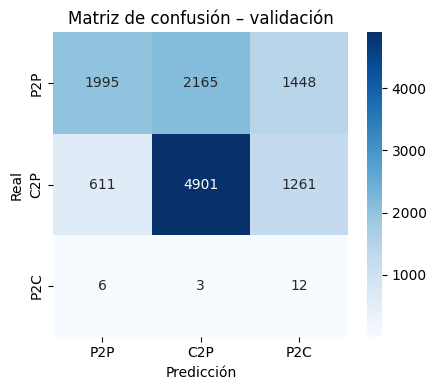


TEST  —  report
              precision    recall  f1-score   support

         P2P     0.7639    0.3642    0.4933      5639
         C2P     0.6919    0.7155    0.7035      6774
         P2C     0.0044    0.5217    0.0087        23

    accuracy                         0.5559     12436
   macro avg     0.4867    0.5338    0.4018     12436
weighted avg     0.7233    0.5559    0.6069     12436



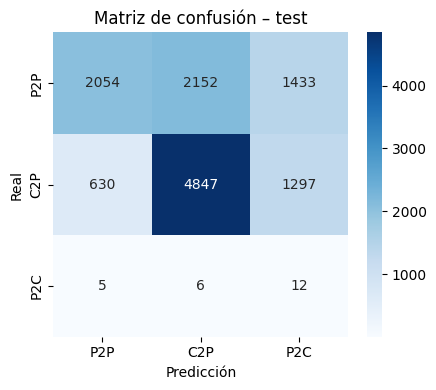

─── Training: GraphSAGE ───
Epoch 00 | loss 1.0945 | acc 0.6406
Epoch 10 | loss 1.0419 | acc 0.7185
Epoch 20 | loss 0.9771 | acc 0.7447
Epoch 30 | loss 0.8882 | acc 0.7321
Epoch 40 | loss 0.7938 | acc 0.7731

VALIDACIÓN  —  report
              precision    recall  f1-score   support

         P2P     0.8161    0.7887    0.8021      5608
         C2P     0.9189    0.7766    0.8418      6773
         P2C     0.0072    0.4286    0.0141        21

    accuracy                         0.7815     12402
   macro avg     0.5807    0.6646    0.5527     12402
weighted avg     0.8709    0.7815    0.8225     12402



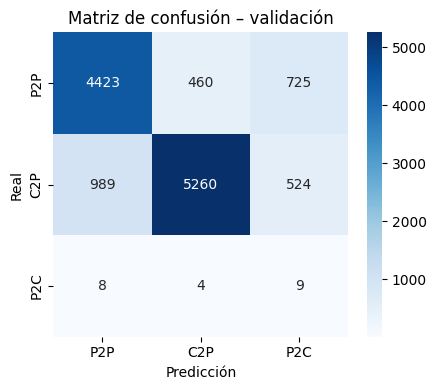


TEST  —  report
              precision    recall  f1-score   support

         P2P     0.8158    0.7907    0.8031      5639
         C2P     0.9201    0.7787    0.8435      6774
         P2C     0.0081    0.4348    0.0159        23

    accuracy                         0.7835     12436
   macro avg     0.5813    0.6681    0.5542     12436
weighted avg     0.8711    0.7835    0.8236     12436



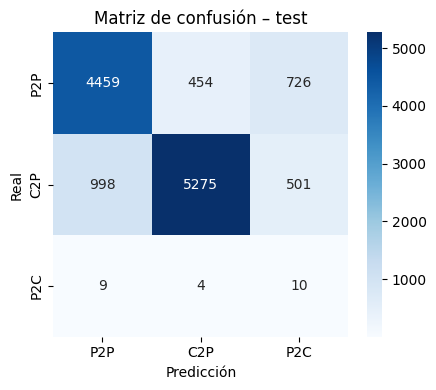

─── Training: GAT ───
Epoch 00 | loss 1.1031 | acc 0.4524
Epoch 10 | loss 1.0939 | acc 0.5086
Epoch 20 | loss 1.0856 | acc 0.7209
Epoch 30 | loss 1.0732 | acc 0.7140
Epoch 40 | loss 1.0520 | acc 0.6372

VALIDACIÓN  —  report
              precision    recall  f1-score   support

         P2P     0.7639    0.5954    0.6692      5608
         C2P     0.8666    0.6607    0.7498      6773
         P2C     0.0052    0.7143    0.0104        21

    accuracy                         0.6313     12402
   macro avg     0.5452    0.6568    0.4765     12402
weighted avg     0.8187    0.6313    0.7121     12402



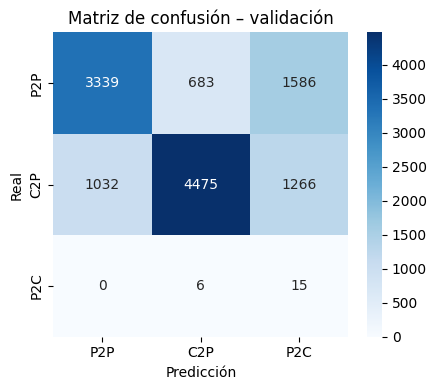


TEST  —  report
              precision    recall  f1-score   support

         P2P     0.7581    0.5884    0.6625      5639
         C2P     0.8606    0.6554    0.7442      6774
         P2C     0.0034    0.4348    0.0068        23

    accuracy                         0.6246     12436
   macro avg     0.5407    0.5595    0.4712     12436
weighted avg     0.8125    0.6246    0.7058     12436



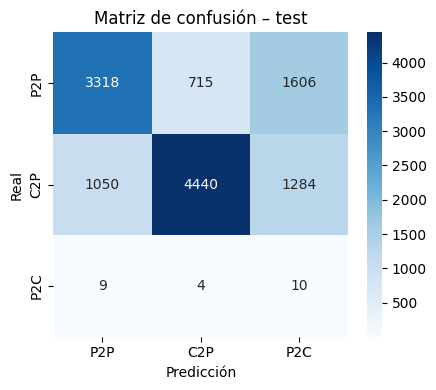

In [18]:
# --- 1.  datos base -------------------------------------------------
in_feats       = gnn.full_g.ndata['feat'].shape[1]
hidden_feats   = 32
out_feats      = 16
out_feats_mlp  = 3                      # 3 clases
device         = "cuda" if torch.cuda.is_available() else "cpu"

# etiquetas SOLO de las aristas con 0/1/2 (train)
labels_train = gnn.train_pos_g.edata['Relationship'].to(torch.int64).to(device)

# pesos por clase (opcional)
from collections import Counter
cnt = Counter(labels_train.tolist())          # ej. {0:318, 1:29, 2:29}
tot = sum(cnt.values())
class_w = torch.tensor([tot/cnt[c] for c in (0,1,2)],
                       dtype=torch.float32, device=device)

# --- 2.  bucle sobre arquitecturas ---------------------------------
for model_name, Model in models.items():
    print(f"─── Training: {model_name} ───")

    model = Model(
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp=out_feats_mlp
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # --- 3.  entrenamiento ----------------------------------------
    for epoch in range(50):
        model.train()

        # 3.1  message-passing con TODO el grafo completo
        h = model.encode(
            gnn.full_g.to(device),
            gnn.full_g.ndata['feat'].to(device)
        )

        # 3.2  logits y pérdida SOLO sobre aristas 0/1/2 de train
        logits = model.decodeMLP(gnn.train_pos_g.to(device), h)
        loss   = F.cross_entropy(logits, labels_train, weight=class_w)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            acc = (logits.argmax(1) == labels_train).float().mean().item()
            print(f"Epoch {epoch:02d} | loss {loss.item():.4f} | acc {acc:.4f}")

    # --- 4.  evaluación -------------------------------------------
    model.eval()
    with torch.no_grad():
        # embeddings con el grafo completo
        h_all = model.encode(
            gnn.full_g.to(device),
            gnn.full_g.ndata['feat'].to(device)
        )

        def eval_split(split_g, name):
            logits = model.decodeMLP(split_g.to(device), h_all)
            y_pred = logits.argmax(1).cpu()
            y_true = split_g.edata['Relationship'].cpu()

            print(f"\n{name.upper()}  —  report")
            print(classification_report(
                y_true, y_pred, labels=[0,1,2],
                target_names=["P2P", "C2P", "P2C"],
                digits=4
            ))

            cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
            plt.figure(figsize=(4.5,4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=["P2P","C2P","P2C"],
                        yticklabels=["P2P","C2P","P2C"])
            plt.title(f"Matriz de confusión – {name}")
            plt.xlabel("Predicción"); plt.ylabel("Real")
            plt.tight_layout(); plt.show()

        eval_split(gnn.val_pos_g,  "validación")
        eval_split(gnn.test_pos_g, "test")


### Caso Antiguo

In [19]:
# Ruta a la data base del proyecto
BASE_PROJECT_PATH = os.getcwd() + "/data/"

# Archivo etiqueta las relaciones
LABEL_EDGES_FILE = DATA_PATH + 'CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
MES = 'febrero'
ANO = '2024'
# Archivo con RIBs
RIB_FILE = DATA_PATH + f'RIBs/sanitized_rib_{MES}_{ANO}.txt'

# Ruta donde se guardaran los grafo DGL
OUTPUT_DIR = BASE_PROJECT_PATH +  f'dgl_graph/{MES}/'
# Definimos las listas de features

# features_file = 'node_degrees' #'' # 'node_degrees' # las features que se le agregaran seran 
# features_file = base_path + "/node_features.csv"
FEATURES_FILE = BASE_PROJECT_PATH + "/node_features_mio_febrero.csv"
# FEATURES_FILE = 'node_features_mio_febrero.csv'
attr = 'node_features_mio_febrero.csv' # 'mio_attr' # 'degree' # 'node_features_mio_febrero.csv'
rib_path = BASE_PROJECT_PATH + 'sanitized_rib_febrero_2024.txt'
MAX_NUM_ROUTES = 1000000
graph_case1 = create_files(
            output_dir = OUTPUT_DIR,
            rib_file = RIB_FILE, 
            features_file = FEATURES_FILE, 
            from_caida = False, 
            label_edges_file = LABEL_EDGES_FILE,
            remove_degree=3,
            debug=True,
            max_paths = MAX_NUM_ROUTES)

print('[NX Graph]',graph_case1.nx_graph)

NameError: name 'DATA_PATH' is not defined

In [50]:
# Comprobar cantidad aristas con y sin etiqueta
from collections import Counter

print('[GRAFO]',gnn.dgl_graph)

rel = gnn.dgl_graph.edata['Relationship']
print("Etiquetas:", (rel >= 0).sum().item(), "con etiqueta  |",
                    (rel < 0).sum().item(),  "sin etiqueta")

print("Etiquetas:", Counter(rel.tolist()))

[GRAFO] Graph(num_nodes=25077, num_edges=124258,
      ndata_schemes={'feat': Scheme(shape=(67,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
Etiquetas: 124258 con etiqueta  | 0 sin etiqueta
Etiquetas: Counter({1: 67825, 0: 56262, 2: 171})


In [ ]:
rel


tensor([-1, -1, -1,  ..., -1, -1, -1])

In [20]:
BASE_PROJECT_PATH = os.getcwd() + "/data/"
dataset_graph_path = BASE_PROJECT_PATH + f'dgl_graph/{MES}/'
 
gnn = GNN(debug=True)
gnn.load_dataset(dataset_graph_path, force_reload=True)

print('[ATTR SHAPE]: ',gnn.dgl_graph.ndata['feat'].shape)
in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
# gnn.split_graph_edges(0.8)
gnn.split_graph_edges_basic(0.8)



Done saving data into cached files.
[load_dataset] Conteo etiquetas 0/1/2/-1 → Counter({1: 67825, 0: 56262, 2: 171})
[ATTR SHAPE]:  torch.Size([25077, 67])
Generando 124258 aristas negativas...
Aristas negativas generadas: 124257


In [21]:
from collections import Counter

labels_train = gnn.train_g.edata["Relationship"]
conteo = Counter(labels_train.tolist())

print(conteo)



labels_train = gnn.test_pos_g.edata["Relationship"]
conteo = Counter(labels_train.tolist())

print(conteo)


labels_train = gnn.train_pos_g.edata["Relationship"]
conteo = Counter(labels_train.tolist())

print(conteo)

Counter({1: 13619, 0: 11192, 2: 41})
Counter({1: 54206, 0: 45070, 2: 130})
Counter({1: 13619, 0: 11192, 2: 41})


Training model: GCN
Epoch 00000 | Loss 1.0530 | Train Acc 0.4594
Epoch 00010 | Loss 0.7166 | Train Acc 0.5083
Epoch 00020 | Loss 0.7137 | Train Acc 0.5479
Epoch 00030 | Loss 0.7081 | Train Acc 0.5474
Epoch 00040 | Loss 0.7043 | Train Acc 0.5480


/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

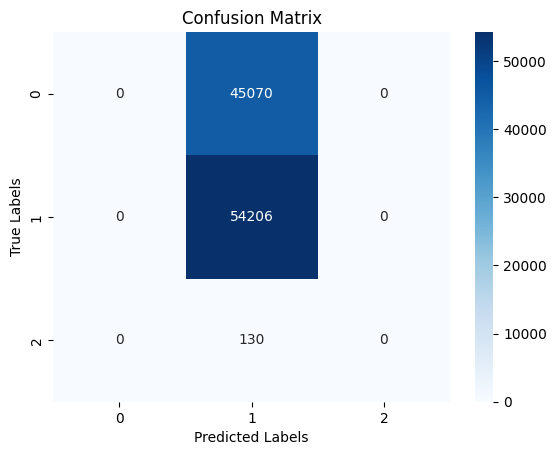

Classification Report:

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     45070
           1     0.5453    1.0000    0.7058     54206
           2     0.0000    0.0000    0.0000       130

    accuracy                         0.5453     99406
   macro avg     0.1818    0.3333    0.2353     99406
weighted avg     0.2974    0.5453    0.3848     99406

Training model: GraphSAGE
Epoch 00000 | Loss 1.0716 | Train Acc 0.4308
Epoch 00010 | Loss 0.7235 | Train Acc 0.4767
Epoch 00020 | Loss 0.7065 | Train Acc 0.5432
Epoch 00030 | Loss 0.7029 | Train Acc 0.5416
Epoch 00040 | Loss 0.6998 | Train Acc 0.5480


/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

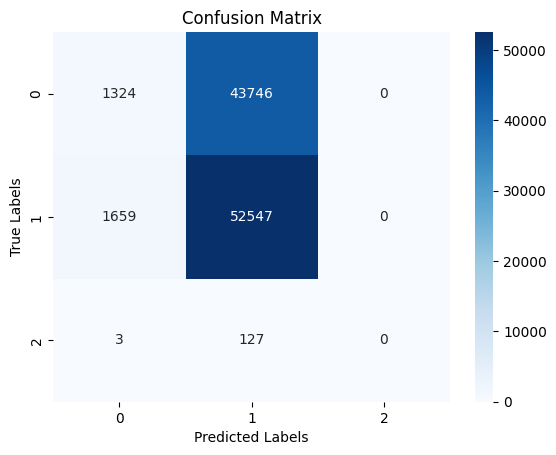

Classification Report:

              precision    recall  f1-score   support

           0     0.4434    0.0294    0.0551     45070
           1     0.5450    0.9694    0.6977     54206
           2     0.0000    0.0000    0.0000       130

    accuracy                         0.5419     99406
   macro avg     0.3295    0.3329    0.2509     99406
weighted avg     0.4982    0.5419    0.4054     99406

Training model: GAT
Epoch 00000 | Loss 1.1992 | Train Acc 0.0024
Epoch 00010 | Loss 0.7030 | Train Acc 0.5478
Epoch 00020 | Loss 0.7144 | Train Acc 0.5474
Epoch 00030 | Loss 0.7094 | Train Acc 0.5478
Epoch 00040 | Loss 0.7033 | Train Acc 0.5480


/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

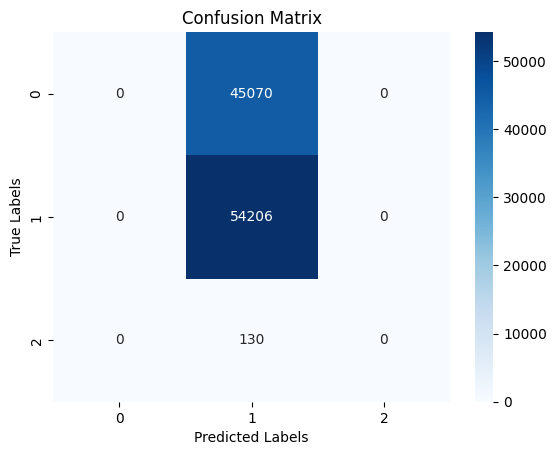

Classification Report:

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     45070
           1     0.5453    1.0000    0.7058     54206
           2     0.0000    0.0000    0.0000       130

    accuracy                         0.5453     99406
   macro avg     0.1818    0.3333    0.2353     99406
weighted avg     0.2974    0.5453    0.3848     99406



In [22]:
decorer = 'DotProduct'
in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
hidden_feats = 32 
out_feats = 16
out_feats_mlp = 3
# etiquetas SOLO de las aristas con 0/1/2
labels_train = gnn.train_pos_g.edata['Relationship'].to(torch.int64)
# labels_train = gnn.train_g.edata["Relationship"].to(torch.int64)

for model_name in models:
    print("Training model: {}".format(model_name))
    
    model = models[model_name](
    in_feats=in_feats,
    hidden_feats=hidden_feats,
    out_feats=out_feats,
    out_feats_mlp=out_feats_mlp,)

    optimizer = torch.optim.Adam(itertools.chain(model.parameters()), lr=0.01)

    # ----------- training -------------------------------- #
    
    
    loss_values = []
    acc_train = []
    train_error = []
    model_complexity = []

    for e in range(50):

        # forward
        model.train()
        h = model.encode(gnn.train_g, gnn.train_g.ndata["feat"])
        # print("h shape: ", h.shape)
        logits = model.decodeMLP(gnn.train_g, h)
        # print("Logits shape: ", logits.shape)
        scores = logits.argmax(1)

        # Calcular la pérdida en el conjunto de entrenamiento
        train_loss = F.cross_entropy(logits, labels_train)
        train_error.append(train_loss.item())
            
        # Guardar la complejidad del modelo (en este caso, usamos el número de épocas)
        model_complexity.append(e + 1)
        
        # Almacenar el valor de pérdida
        loss_values.append(train_loss.item())
        
        # Calcular la precisión en el conjunto de entrenamiento
        train_acc = (scores == labels_train).float().mean().item()

        # backward
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if e % 10 == 0:
            print("Epoch {:05d} | Loss {:.4f} | Train Acc {:.4f}".format(e, train_loss.item(), train_acc))

        
    # ----------- 5. check results ------------------------ #


    with torch.no_grad():
        h = model.encode(gnn.test_pos_g, gnn.test_pos_g.ndata["feat"])
        logits_test = model.decodeMLP(gnn.test_pos_g, h)
        # print("Logits test shape: ", logits_test.shape)
        predicted_scores_test = logits_test.argmax(1)
        true_values_test = gnn.test_pos_g.edata["Relationship"].to(torch.int64)
        
        conf_matrix = confusion_matrix(true_values_test, predicted_scores_test)
        report = classification_report(true_values_test, predicted_scores_test, digits=4)

        # Graficar la matriz de confusión
        plt.figure()
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

        print("Classification Report:\n")
        print(report)  
    


    
    # # Guaradar el modelo
    # torch.save(model.state_dict(), f'data/model_emb_{model_name}.pth')

    # # Guardar los embeddings
    # torch.save(h, f"data/embeddings_ribs_DP_{model_name}.pt")


     
    


### CASO 0

In [8]:
# Asumiendo que tu grafo vive en gnn.dgl_graph

# INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024'
# INTERNETGRAPH_FILE ='/media/valentina/KINGSTON/TESIS/InternetGNNData2022/'
INTERNETGRAPH_FILE = 'data/dgl_graphs/'
 
RELATIONSHIPS_FILE = 'data/' + 'CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    caida_path=None  # Archivo CAIDA AS Relationships
)
gnn.split_dataset_v0()

print(gnn.dgl_graph)




Done saving data into cached files.
[load_dataset] Conteo etiquetas 0/1/2/-1 → Counter({0: 668732, 1: 154411, 2: 154411})
Training edges: 586710
Validation edges: 195540
Test edges: 195304
Graph(num_nodes=76415, num_edges=977554,
      ndata_schemes={'feat': Scheme(shape=(67,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})


In [9]:
class_names = ['P2P', 'C2P', 'P2C']

num_classes = len(class_names)


In [ ]:
decoder = 'MLP'
in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
hidden_feats = 32 
out_feats = 32

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mask = gnn.test_mask
val_mask = gnn.val_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16

for model_name in models:

    print("Training model: {} ----------------------------------------------- \n".format(model_name))

    model = models[model_name](
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp = 4  )
    

    # ----------- 3. set up loss and optimizer -------------- #

    optimizer = torch.optim.Adam(itertools.chain(model.parameters()), lr=0.01)

    # ----------- 4. training -------------------------------- #

    # Lista para almacenar los valores de pérdida
    loss_values = []

    acc_val = []
    acc_train = []



    train_error = []
    val_error = []
    model_complexity = []

    for e in range(100):
        # forward
        model.train()

        h = model.encode(gnn.dgl_graph, gnn.dgl_graph.ndata["feat"])
        logits = model.decodeMLP(gnn.dgl_graph, h)

        scores = logits.argmax(1)
        labels = gnn.dgl_graph.edata["Relationship"].to(torch.int64)

        # Calcular la pérdida en el conjunto de entrenamiento
        train_loss = F.cross_entropy(logits[train_mask], labels[train_mask], ignore_index=-1)  # ignora todas las posiciones donde label == -1
 
        train_error.append(train_loss.item())

        # Calcular la pérdida en el conjunto de validación
        val_loss = F.cross_entropy(logits[gnn.val_mask], labels[gnn.val_mask], ignore_index=-1)  # ignora todas las posiciones donde label == -1
        val_error.append(val_loss.item())

        # Guardar la complejidad del modelo (en este caso, usamos el número de épocas)
        model_complexity.append(e + 1)

        # Almacenar el valor de pérdida
        loss_values.append(train_loss.item())

        # Calcular la precisión en el conjunto de entrenamiento
        train_acc = (scores[train_mask] == labels[train_mask]).float().mean().item()

        # Calcular la precisión en el conjunto de validación
        val_acc = (scores[gnn.val_mask] == labels[gnn.val_mask]).float().mean().item()

        # Guardar los valores de precisión
        acc_train.append(train_acc)
        acc_val.append(val_acc)

        # backward
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if e % 10 == 0:
            print('In epoch {}, train loss: {}, val loss: {}'.format(e, train_loss, val_loss))


    # ----------- 5. Graficar precisión y pérdida -------------- #
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # --- (a) Accuracy por época --------------------------------
    axs[0].plot(acc_train, label='Entrenamiento', linewidth=2)
    axs[0].plot(acc_val,   label='Validación',   linewidth=2)
    axs[0].set_title('Accuracy por época')
    axs[0].set_xlabel('Época')
    axs[0].set_ylabel('Precisión')
    axs[0].legend()
    axs[0].grid(True)

    # --- (b) Pérdida por época ---------------------------------
    axs[1].plot(model_complexity, train_error, label='Entrenamiento', linewidth=2)
    axs[1].plot(model_complexity, val_error,   label='Validación',   linewidth=2)
    axs[1].set_title('Pérdida vs. complejidad del modelo')
    axs[1].set_xlabel('Época')
    axs[1].set_ylabel('Cross-entropy loss')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import (confusion_matrix, classification_report,
                                 accuracy_score, precision_recall_fscore_support)

    # -------------------------------------------------------------------
    # (2)  OBTENER PREDICCIONES Y MATRIZ
    # -------------------------------------------------------------------
    model.eval()
    with torch.no_grad():
        h      = model.encode(gnn.dgl_graph, gnn.dgl_graph.ndata["feat"])
        logits = model.decodeMLP(gnn.dgl_graph, h)

    mask   = gnn.test_mask                               # o val_mask
    y_true = gnn.dgl_graph.edata["Relationship"][mask].cpu().numpy()
    y_pred = logits[mask].argmax(dim=-1).cpu().numpy()

    conf_mat = confusion_matrix(y_true, y_pred,
                                labels=range(num_classes))



    # -------------------------------------------------------------------
    # (3)  GRAFICAR
    # -------------------------------------------------------------------
    class_names = [f"Clase {i}" for i in range(num_classes)]
    num_classes = 3                     # o model.out_feats_mlp
    class_names = [f"Clase {i}" for i in range(num_classes)]

    # Matriz sin normalizar
    plot_confusion_matrix(conf_mat,
                          classes=class_names,
                          normalize=False,
                          title="Matriz de confusión (conteos)",
                          fname="confusion_counts",
                          cmap=plt.cm.Blues,
                          save=True)

    # Matriz normalizada
    plot_confusion_matrix(conf_mat,
                          classes=class_names,
                          normalize=True,
                          title="Matriz de confusión normalizada",
                          fname="confusion_norm",
                          cmap=plt.cm.Blues,
                          save=True)


    # 6.3 Cálculo de métricas
    acc_global = accuracy_score(y_true, y_pred)
    prec, rec, f1, support = precision_recall_fscore_support(
        y_true, y_pred,
        labels=range(num_classes),
        zero_division=0
    )
    macro_prec, macro_rec, macro_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    weighted_prec, weighted_rec, weighted_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )

    # 6.4 Impresión por consola
    print("\n===== RESUMEN MÉTRICO =====")
    print(f"Accuracy global      : {acc_global:.4f}\n")

    for i, name in enumerate(class_names):
        print(f"[{name}]  P: {prec[i]:.3f}  R: {rec[i]:.3f}  F1: {f1[i]:.3f}  Soporte: {support[i]}")
    print("\n--- Promedios ---")
    print(f"Macro    → P:{macro_prec:.3f}  R:{macro_rec:.3f}  F1:{macro_f1:.3f}")
    print(f"Weighted → P:{weighted_prec:.3f}  R:{weighted_rec:.3f}  F1:{weighted_f1:.3f}")

    print("\n=== classification_report ===")
    print(classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        digits=3,
        zero_division=0
    ))

Viendo estos resultados igual me hace pensar que hay algun information leak , por el garfico de loss y accuracy que tenemos  ya que el test y y validacion son muy iguales y no suce de un sobreajuste donde se van deferiendo los puntajes despues de cierto punto.

# CASO 0.1
Arrgelar funcion de split donde ponemos ariat hacia ambos lados en el mismo conjunto de training y validacion.

In [16]:
# Asumiendo que tu grafo vive en gnn.dgl_graph
class_names = ['P2P', 'C2P', 'P2C']

num_classes = len(class_names)

# INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024'
# INTERNETGRAPH_FILE ='/media/valentina/KINGSTON/TESIS/InternetGNNData2022/'
INTERNETGRAPH_FILE = 'data/dgl_graphs/'
 
RELATIONSHIPS_FILE = 'data/' + 'CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    caida_path=None  # Archivo CAIDA AS Relationships
)
gnn.split_dataset_v01(train_ratio = 0.2,)

print(gnn.dgl_graph)



Done saving data into cached files.
[load_dataset] Conteo etiquetas 0/1/2/-1 → Counter({0: 668732, 1: 154411, 2: 154411})
Training edges: 195398 (19.99%)
Validation edges: 194836 (19.93%)
Test edges: 587320 (60.08%)
Graph(num_nodes=76415, num_edges=977554,
      ndata_schemes={'feat': Scheme(shape=(67,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})


Training model: GCN ----------------------------------------------- 

In epoch 0, train loss: 1.4295815229415894, val loss: 1.4297055006027222
In epoch 10, train loss: 0.5404859185218811, val loss: 0.535735011100769
In epoch 20, train loss: 0.3766966462135315, val loss: 0.3739352822303772
In epoch 30, train loss: 0.3104343116283417, val loss: 0.3083788752555847
In epoch 40, train loss: 0.26781538128852844, val loss: 0.26517874002456665
In epoch 50, train loss: 0.2568632960319519, val loss: 0.25373199582099915
In epoch 60, train loss: 0.24425753951072693, val loss: 0.2420009821653366
In epoch 70, train loss: 0.23662424087524414, val loss: 0.23479308187961578
In epoch 80, train loss: 0.22999462485313416, val loss: 0.22876420617103577
In epoch 90, train loss: 0.2202530950307846, val loss: 0.21912814676761627


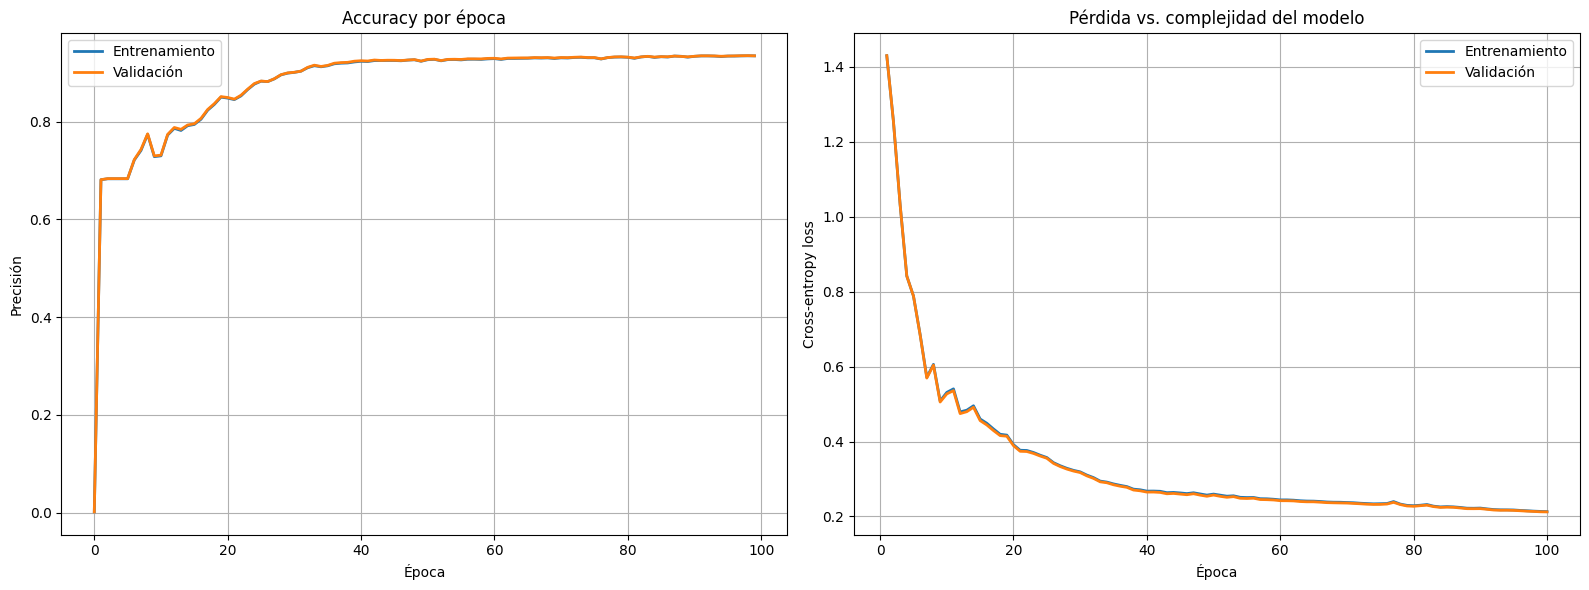

Matriz de confusión sin normalizar


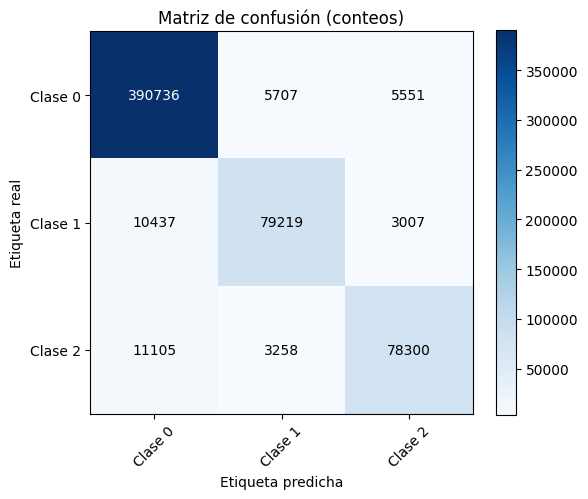

Matriz de confusión normalizada


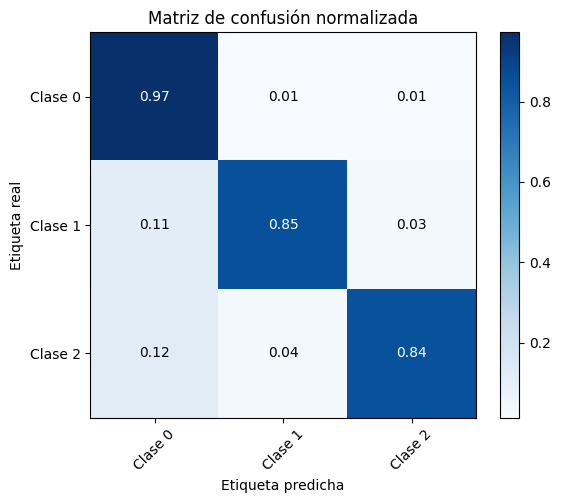


===== RESUMEN MÉTRICO =====
Accuracy global      : 0.9335

[Clase 0]  P: 0.948  R: 0.972  F1: 0.960  Soporte: 401994
[Clase 1]  P: 0.898  R: 0.855  F1: 0.876  Soporte: 92663
[Clase 2]  P: 0.901  R: 0.845  F1: 0.872  Soporte: 92663

--- Promedios ---
Macro    → P:0.916  R:0.891  F1:0.903
Weighted → P:0.933  R:0.933  F1:0.933

=== classification_report ===
              precision    recall  f1-score   support

     Clase 0      0.948     0.972     0.960    401994
     Clase 1      0.898     0.855     0.876     92663
     Clase 2      0.901     0.845     0.872     92663

    accuracy                          0.933    587320
   macro avg      0.916     0.891     0.903    587320
weighted avg      0.933     0.933     0.933    587320

Training model: GraphSAGE ----------------------------------------------- 

In epoch 0, train loss: 1.3742790222167969, val loss: 1.374436378479004
In epoch 10, train loss: 0.5162482261657715, val loss: 0.5130102038383484
In epoch 20, train loss: 0.363954722881

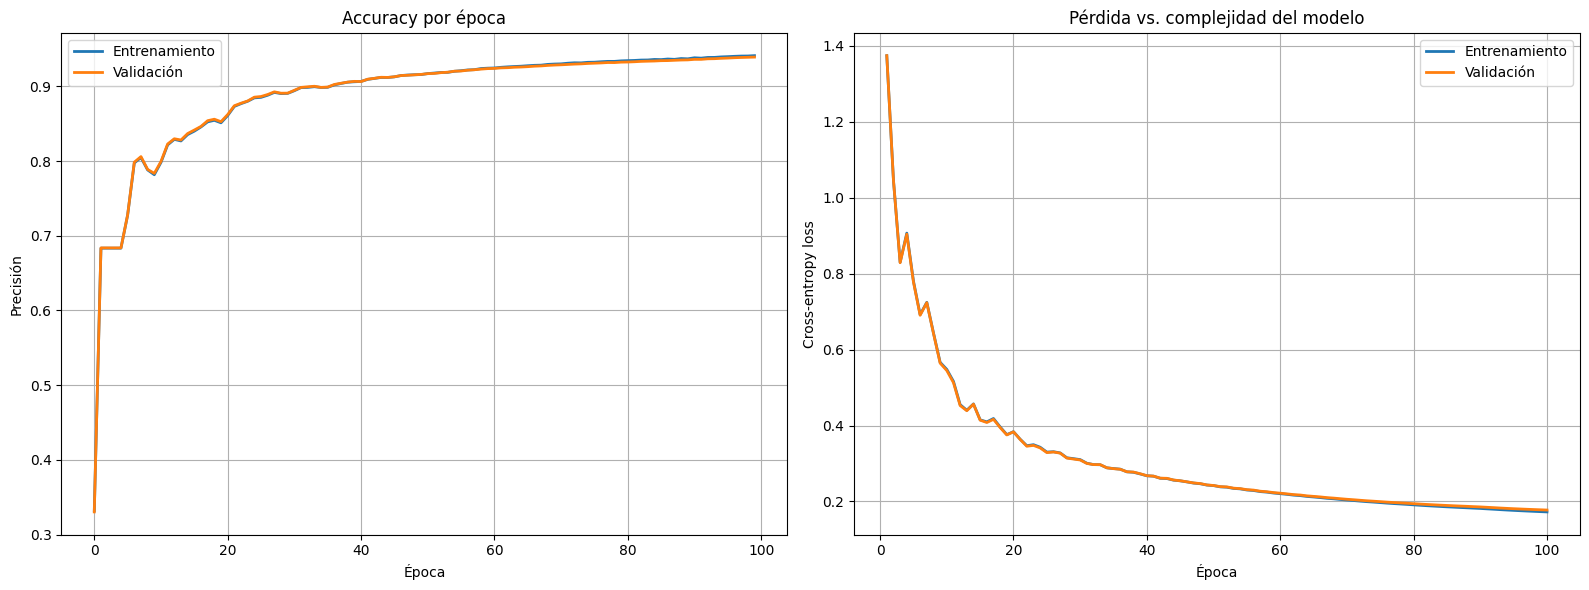

Matriz de confusión sin normalizar


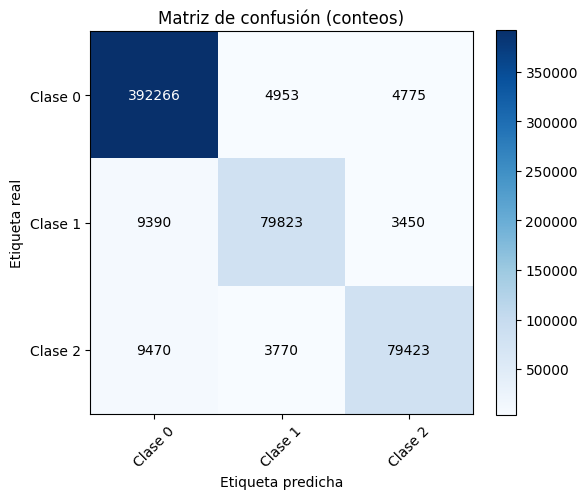

Matriz de confusión normalizada


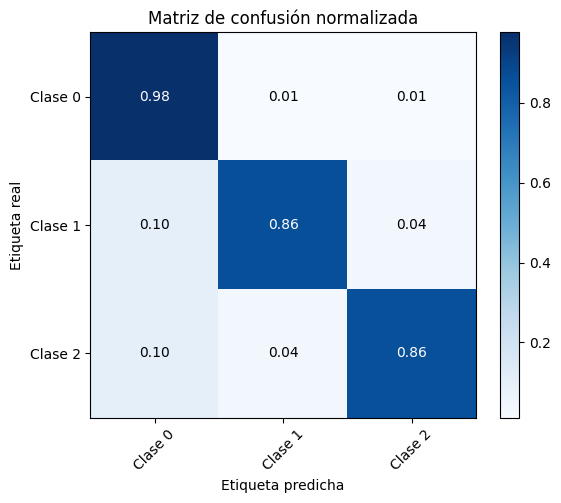


===== RESUMEN MÉTRICO =====
Accuracy global      : 0.9390

[Clase 0]  P: 0.954  R: 0.976  F1: 0.965  Soporte: 401994
[Clase 1]  P: 0.901  R: 0.861  F1: 0.881  Soporte: 92663
[Clase 2]  P: 0.906  R: 0.857  F1: 0.881  Soporte: 92663

--- Promedios ---
Macro    → P:0.921  R:0.898  F1:0.909
Weighted → P:0.938  R:0.939  F1:0.938

=== classification_report ===
              precision    recall  f1-score   support

     Clase 0      0.954     0.976     0.965    401994
     Clase 1      0.901     0.861     0.881     92663
     Clase 2      0.906     0.857     0.881     92663

    accuracy                          0.939    587320
   macro avg      0.921     0.898     0.909    587320
weighted avg      0.938     0.939     0.938    587320

Training model: GAT ----------------------------------------------- 

In epoch 0, train loss: 1.2991523742675781, val loss: 1.2991282939910889
In epoch 10, train loss: 0.7540393471717834, val loss: 0.7529990673065186
In epoch 20, train loss: 0.5990503430366516,

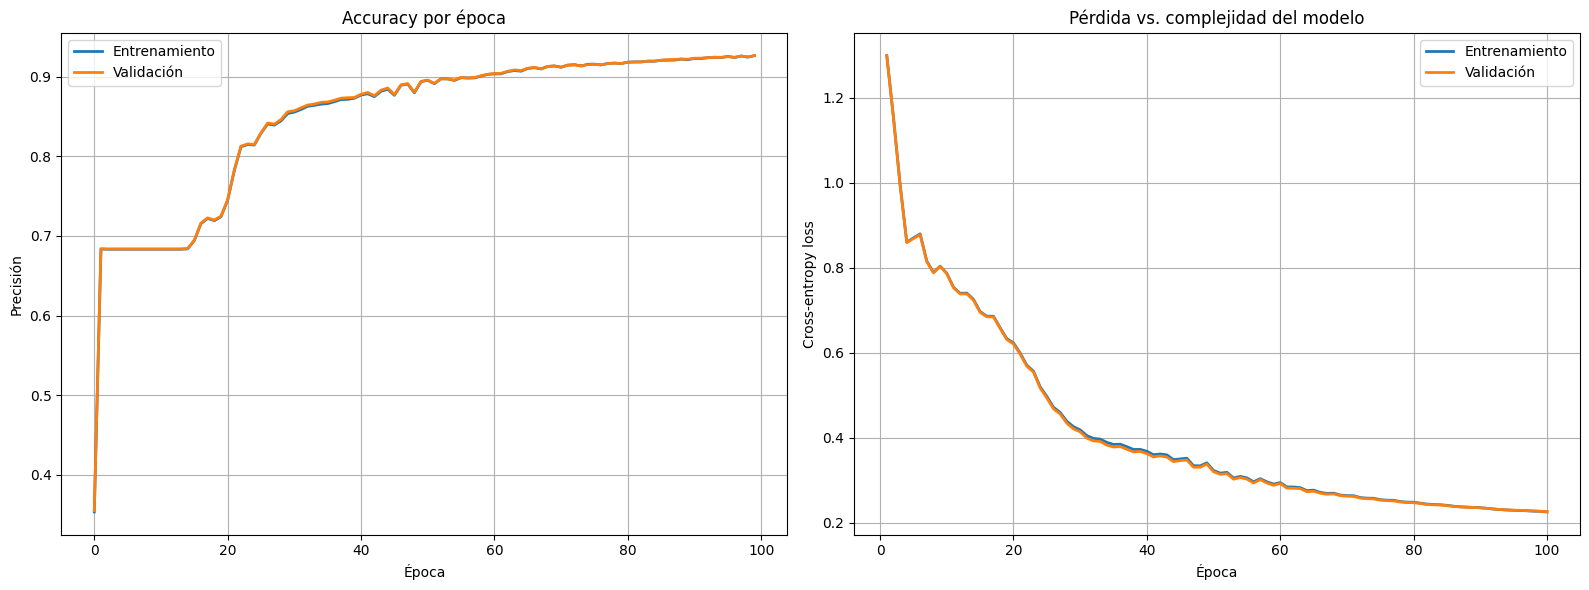

Matriz de confusión sin normalizar


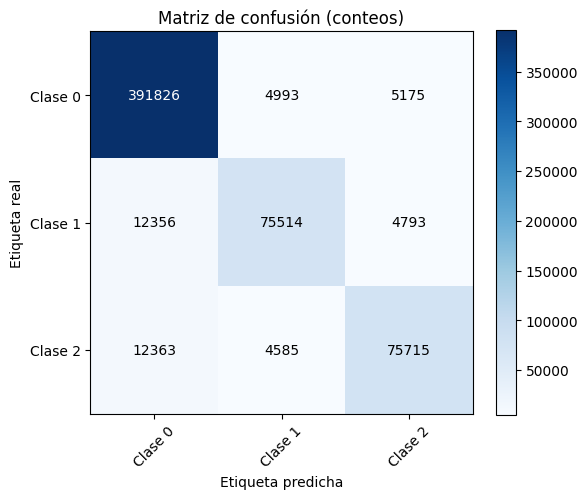

Matriz de confusión normalizada


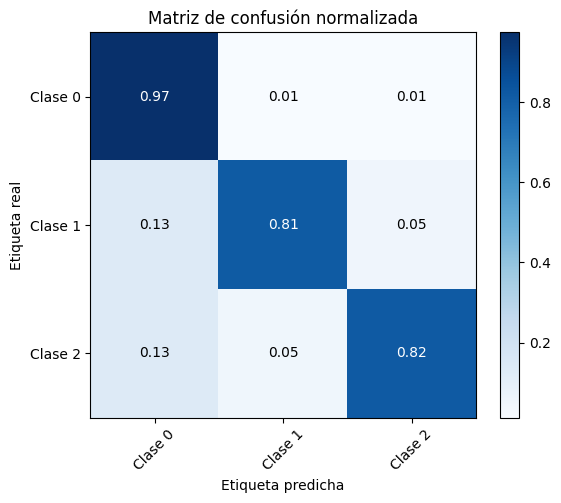


===== RESUMEN MÉTRICO =====
Accuracy global      : 0.9246

[Clase 0]  P: 0.941  R: 0.975  F1: 0.957  Soporte: 401994
[Clase 1]  P: 0.887  R: 0.815  F1: 0.850  Soporte: 92663
[Clase 2]  P: 0.884  R: 0.817  F1: 0.849  Soporte: 92663

--- Promedios ---
Macro    → P:0.904  R:0.869  F1:0.885
Weighted → P:0.923  R:0.925  F1:0.923

=== classification_report ===
              precision    recall  f1-score   support

     Clase 0      0.941     0.975     0.957    401994
     Clase 1      0.887     0.815     0.850     92663
     Clase 2      0.884     0.817     0.849     92663

    accuracy                          0.925    587320
   macro avg      0.904     0.869     0.885    587320
weighted avg      0.923     0.925     0.923    587320



In [17]:
decoder = 'MLP'
in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
hidden_feats = 32 
out_feats = 32

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mask = gnn.test_mask
val_mask = gnn.val_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16

for model_name in models:

    print("Training model: {} ----------------------------------------------- \n".format(model_name))

    model = models[model_name](
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp = 4  )
    

    # ----------- 3. set up loss and optimizer -------------- #

    optimizer = torch.optim.Adam(itertools.chain(model.parameters()), lr=0.01)

    # ----------- 4. training -------------------------------- #

    # Lista para almacenar los valores de pérdida
    loss_values = []

    acc_val = []
    acc_train = []



    train_error = []
    val_error = []
    model_complexity = []

    for e in range(100):
        # forward
        model.train()

        h = model.encode(gnn.dgl_graph, gnn.dgl_graph.ndata["feat"])
        logits = model.decodeMLP(gnn.dgl_graph, h)

        scores = logits.argmax(1)
        labels = gnn.dgl_graph.edata["Relationship"].to(torch.int64)

        # Calcular la pérdida en el conjunto de entrenamiento
        train_loss = F.cross_entropy(logits[train_mask], labels[train_mask], ignore_index=-1)  # ignora todas las posiciones donde label == -1
 
        train_error.append(train_loss.item())

        # Calcular la pérdida en el conjunto de validación
        val_loss = F.cross_entropy(logits[gnn.val_mask], labels[gnn.val_mask], ignore_index=-1)  # ignora todas las posiciones donde label == -1
        val_error.append(val_loss.item())

        # Guardar la complejidad del modelo (en este caso, usamos el número de épocas)
        model_complexity.append(e + 1)

        # Almacenar el valor de pérdida
        loss_values.append(train_loss.item())

        # Calcular la precisión en el conjunto de entrenamiento
        train_acc = (scores[train_mask] == labels[train_mask]).float().mean().item()

        # Calcular la precisión en el conjunto de validación
        val_acc = (scores[gnn.val_mask] == labels[gnn.val_mask]).float().mean().item()

        # Guardar los valores de precisión
        acc_train.append(train_acc)
        acc_val.append(val_acc)

        # backward
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if e % 10 == 0:
            print('In epoch {}, train loss: {}, val loss: {}'.format(e, train_loss, val_loss))


    # ----------- 5. Graficar precisión y pérdida -------------- #
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # --- (a) Accuracy por época --------------------------------
    axs[0].plot(acc_train, label='Entrenamiento', linewidth=2)
    axs[0].plot(acc_val,   label='Validación',   linewidth=2)
    axs[0].set_title('Accuracy por época')
    axs[0].set_xlabel('Época')
    axs[0].set_ylabel('Precisión')
    axs[0].legend()
    axs[0].grid(True)

    # --- (b) Pérdida por época ---------------------------------
    axs[1].plot(model_complexity, train_error, label='Entrenamiento', linewidth=2)
    axs[1].plot(model_complexity, val_error,   label='Validación',   linewidth=2)
    axs[1].set_title('Pérdida vs. complejidad del modelo')
    axs[1].set_xlabel('Época')
    axs[1].set_ylabel('Cross-entropy loss')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import (confusion_matrix, classification_report,
                                 accuracy_score, precision_recall_fscore_support)

    # -------------------------------------------------------------------
    # (2)  OBTENER PREDICCIONES Y MATRIZ
    # -------------------------------------------------------------------
    model.eval()
    with torch.no_grad():
        h      = model.encode(gnn.dgl_graph, gnn.dgl_graph.ndata["feat"])
        logits = model.decodeMLP(gnn.dgl_graph, h)

    mask   = gnn.test_mask                               # o val_mask
    y_true = gnn.dgl_graph.edata["Relationship"][mask].cpu().numpy()
    y_pred = logits[mask].argmax(dim=-1).cpu().numpy()

    conf_mat = confusion_matrix(y_true, y_pred,
                                labels=range(num_classes))



    # -------------------------------------------------------------------
    # (3)  GRAFICAR
    # -------------------------------------------------------------------
    class_names = [f"Clase {i}" for i in range(num_classes)]
    num_classes = 3                     # o model.out_feats_mlp
    class_names = [f"Clase {i}" for i in range(num_classes)]

    # Matriz sin normalizar
    plot_confusion_matrix(conf_mat,
                          classes=class_names,
                          normalize=False,
                          title="Matriz de confusión (conteos)",
                          fname="confusion_counts",
                          cmap=plt.cm.Blues,
                          save=True)

    # Matriz normalizada
    plot_confusion_matrix(conf_mat,
                          classes=class_names,
                          normalize=True,
                          title="Matriz de confusión normalizada",
                          fname="confusion_norm",
                          cmap=plt.cm.Blues,
                          save=True)


    # 6.3 Cálculo de métricas
    acc_global = accuracy_score(y_true, y_pred)
    prec, rec, f1, support = precision_recall_fscore_support(
        y_true, y_pred,
        labels=range(num_classes),
        zero_division=0
    )
    macro_prec, macro_rec, macro_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    weighted_prec, weighted_rec, weighted_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )

    # 6.4 Impresión por consola
    print("\n===== RESUMEN MÉTRICO =====")
    print(f"Accuracy global      : {acc_global:.4f}\n")

    for i, name in enumerate(class_names):
        print(f"[{name}]  P: {prec[i]:.3f}  R: {rec[i]:.3f}  F1: {f1[i]:.3f}  Soporte: {support[i]}")
    print("\n--- Promedios ---")
    print(f"Macro    → P:{macro_prec:.3f}  R:{macro_rec:.3f}  F1:{macro_f1:.3f}")
    print(f"Weighted → P:{weighted_prec:.3f}  R:{weighted_rec:.3f}  F1:{weighted_f1:.3f}")

    print("\n=== classification_report ===")
    print(classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        digits=3,
        zero_division=0
    ))

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Matriz de confusión',
                          fname=None,
                          cmap=plt.cm.Blues,
                          save=False):
    """
    Esta función imprime y grafica la matriz de confusión.
    La normalización puede aplicarse configurando `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confusión sin normalizar')

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Etiqueta real')
    plt.xlabel('Etiqueta predicha')
    plt.tight_layout()
    
    if save and fname is not None:
        plt.savefig(f"{fname}.png", dpi=300, bbox_inches='tight')
    plt.show()
